# Programa de capacitação

**Introdução à comunicações digitais**

Adolfo Fernandes Herbster

<a href="https://sites.google.com/a/dee.ufcg.edu.br/adolfo-herbster/" target="_blank">https://sites.google.com/a/dee.ufcg.edu.br/adolfo-herbster/</a>

<a href="mailto:adolfofh@dee.ufcg.edu.br">adolfofh@dee.ufcg.edu.br</a>

Embedded/DEE/CEEI/UFCG - 2019

# Quantização

Formalmente, a saída quantizada $Q[x]$ do valor $x$, é dada por

$$Q[x] = \arg \min_{l\in\mathcal{S}} |l-x|.$$

em que $\mathcal{S}$ contém todos os possíveis valores de saída do quantizador (*níveis de quantização*). Há basicamente dois tipos de quantizadores: *mid-rise* e o *mid-tread*. Os níveis dos quantizadores são dados por

\begin{align}
\mathcal{S} &= \{-U+\frac{\Delta_s}{2}+\Delta_s\cdot(0,1,2,\dots, q-1)\}&\text{ se mid-rise}\\
\mathcal{S} &= \{-U+\Delta_s\cdot(0,1,2,\dots, q-1)\}&\text{ se mid-tread}
\end{align}

## Exemplos de um quantizador

In [6]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
import time 
from ipywidgets import interact
from matplotlib import animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.writer'] = 'avconv'
# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

In [7]:
b = 2            # número de bits do quantizador
q = 2**b         # número de níveis do quantizador
U = 1            # amplitude máxima do quantizador
Delta_s = 2*U/q  # distância de nível do quantizador

S_midrise = -U + Delta_s/2 + np.arange(q)*Delta_s
S_midtread = -U  + np.arange(q)*Delta_s

In [8]:
def quantize(x, S):
    X = x.reshape((-1,1))
    S = S.reshape((1,-1))
    dists = abs(X-S)
    
    nearestIndex = dists.argmin(axis=1)
    quantized = S.flat[nearestIndex]
    
    return quantized.reshape(x.shape)

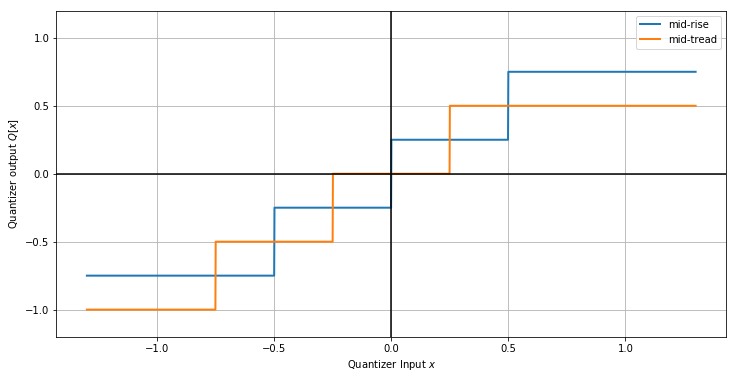

In [10]:
plt.figure(figsize=(12,6));
In = np.linspace(-1.3*U, 1.3*U, 2000)
Out_midrise = quantize(In, S_midrise)
Out_midtread = quantize(In, S_midtread)
plt.plot(In, Out_midrise, lw=2, label='mid-rise')
plt.plot(In, Out_midtread, lw=2, label='mid-tread')
plt.axvline(0, color='k'); plt.axhline(0, color='k'); plt.legend(fontsize=10)
plt.grid(True); plt.ylim((-1.2, 1.2)); plt.xlabel('Quantizer Input $x$'); plt.ylabel('Quantizer output $Q[x]$');

## Ruído de quantização
\begin{align}
s_q(t)&=Q[s(t)]&&\text{Quantization operation}\\
n_q(t)&=s(t)-s_q(t)&&\text{Expression of quantization noise}\\
s_q(t)&=s(t)-n_q(t)
\end{align}

In [11]:
def calcLevels(U, b, quantization_type):
    N_levels = 2**b
    delta = 2*U / N_levels
    
    if quantization_type == 'mid-rise':
        levels = -U + delta/2 + np.arange(N_levels) * delta 
    elif quantization_type == 'mid-tread':
        levels = -U + np.arange(N_levels) * delta
    else:
        raise RuntimeError("Unknown quantization type!")
    
    return levels

In [15]:
Fs = 100  # taxa de amostragem
f = 1     # frequência do sinal
T = 3     # duração do sinal
t = np.arange(0, T, 1/Fs)
s = np.sin(2*np.pi*f*t)
def showQuantizationNoise(b):    
    plt.gcf().clear()
    S = calcLevels(U, b, 'mid-rise')
    s_q = quantize(s, S)
    n_q = s - s_q
    plt.figure(figsize=(12,6));
    plt.plot(t, s, label='$s(t)$')
    plt.plot(t, s_q, lw=2, label='$s_q(t)$')
    plt.plot(t, n_q, label='$n_q(t)$');
    plt.text(0.25, -0.5, 'b=%d' % b, ha='center', bbox=dict(facecolor='white'))
    plt.legend(fontsize=10); plt.xlabel('$t$'); plt.grid(); plt.axhline(0, color='k');
    showInInteract()

In [16]:
interact(showQuantizationNoise, b=(1,8));

interactive(children=(IntSlider(value=4, description='b', max=8, min=1), Output()), _dom_classes=('widget-inte…

Para um sinal senoidal a relação sinal ruído de quantização é expresso por 

$$SNR\approx (1.76 + 6.02b)dB,$$

em que $b$ é o número de bits utilizado na quantização.

In [17]:
def calcQuantizationNoise(signal, b):
    S = calcLevels(U, b, 'mid-rise')
    signal_q = quantize(signal, S)
    n_q = signal - signal_q
    
    P_S = (signal**2).sum()
    P_N = (n_q**2).sum()
    
    SNR = 10*np.log10(P_S/P_N)  # use 
    return SNR

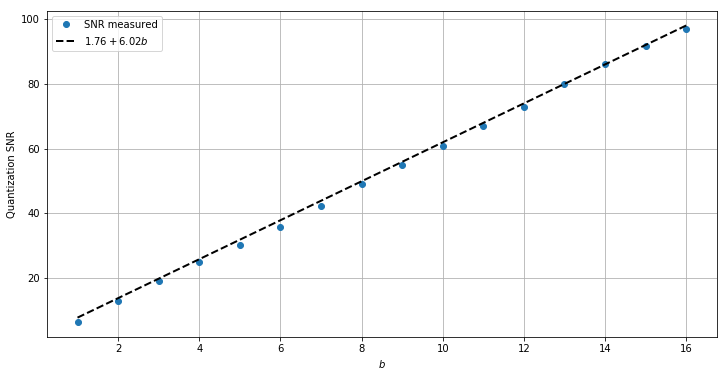

In [21]:
bits = np.arange(1, 17)
SNR = [calcQuantizationNoise(np.sin(2*np.pi*t*f), b) for b in bits]
plt.figure(figsize=(12,6));
plt.plot(bits, SNR, 'o', label='SNR measured')
plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2, label='$1.76+6.02b$')
plt.grid(True); 
plt.xlabel('$b$'); 
plt.ylabel('Quantization SNR');
plt.legend();

### O que ocorre quando é reduzida a amplitude do sinal?

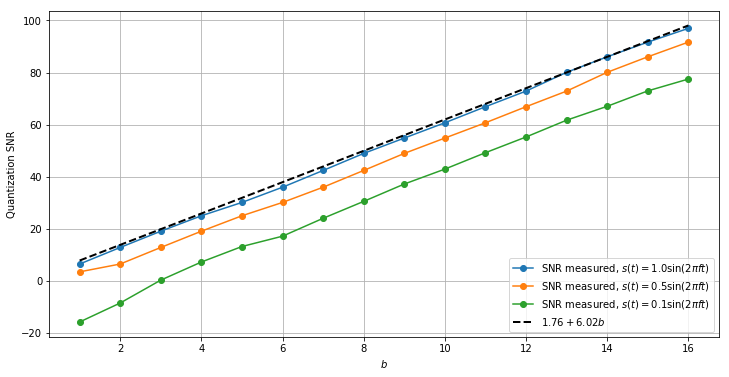

In [24]:
plt.figure(figsize=(12,6));
for A in [1, 0.5, 0.1]:
    SNR = [calcQuantizationNoise(A*np.sin(2*np.pi*t*f), b) for b in bits]
    plt.plot(bits, SNR, 'o-', label=r'SNR measured, $s(t)=%.1f \sin(2\pi ft)$' % A)
plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2,label='$1.76+6.02b$')
plt.legend(fontsize=10, loc='lower right')
plt.grid(True); plt.xlabel('$b$'); plt.ylabel('Quantization SNR');

### O que aconteceu com a expressão do ruído de quantização? Qual a característica que é mantida?

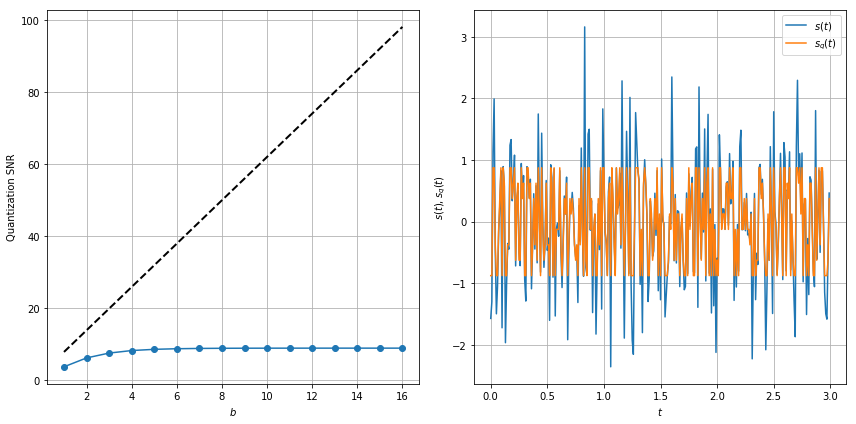

In [26]:
signal = np.random.randn(len(t))  # generate some random signal

plt.figure(figsize=(12,6))
plt.subplot(121)
SNR_noise = [calcQuantizationNoise(signal, b) for b in bits]
plt.plot(bits, SNR_noise, 'o-', label=r'SNR measured, $s(t)=%.1f \sin(2\pi ft)$' % A)
plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2,label='$1.76+6.02b$')
plt.legend(fontsize=10);
plt.grid(True); 
plt.xlabel('$b$');
plt.ylabel('Quantization SNR');

plt.subplot(122)
signal_q = quantize(signal, calcLevels(U, 3, 'mid-rise'))
plt.plot(t, signal, label='$s(t)$')
plt.plot(t, signal_q, label='$s_q(t)$')
plt.grid(True); plt.ylabel('$s(t), s_q(t)$'); plt.xlabel('$t$');
plt.legend(fontsize=10);
plt.tight_layout();

### O que aconteceu com o quantizador apesar de utilizar um maior número de bits?

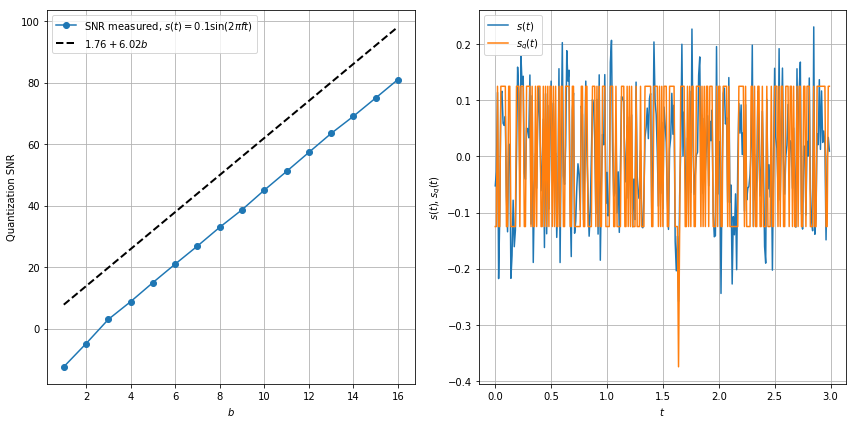

In [29]:
signal = 0.1 * np.random.randn(len(t)) # menor ruído aditivo

plt.figure(figsize=(12,6))
plt.subplot(121)
SNR_noise = [calcQuantizationNoise(signal, b) for b in bits]
plt.plot(bits, SNR_noise, 'o-', label=r'SNR measured, $s(t)=%.1f \sin(2\pi ft)$' % A)
plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2,label='$1.76+6.02b$')
plt.legend(fontsize=10);
plt.grid(True);
plt.xlabel('$b$');
plt.ylabel('Quantization SNR');

plt.subplot(122)
signal_q = quantize(signal, calcLevels(U, 3, 'mid-rise'))
plt.plot(t, signal, label='$s(t)$')
plt.plot(t, signal_q, label='$s_q(t)$')
plt.grid(True);
plt.ylabel('$s(t), s_q(t)$');
plt.xlabel('$t$');
plt.legend(fontsize=10);
#plt.xlim((0,0.3))
plt.tight_layout();

### Por qual motivo o sinal quantizado concentra-se limita-se em [-0.1,0.1]?